## Week 4 Jupyter Ntoebook
For Week 4, include concepts such as logistic regression and feature scaling.

Ok, we're back in classifier territory, let's fire up the injury prediction sets:

### Punt Analytics Dataset

### Logistic Regression Implementation

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [105]:
import pandas as pd
df = pd.read_csv('/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/NFL-Punt-Analytics-Competition/punt_analytics_v3.csv')
df = df.drop(columns=['season_year', 'gamekey', 'playid', 'gsisid', 'time_min', 'time_max', 'event_first', 'role'])
for col in df.columns:
    df[col] = df[col].replace(np.inf, 0)

In [106]:
# Let's explore the data to identify potential missing or infinite values
print("Before replacement:")
print(f"Number of infinite values in the DataFrame: {np.sum(np.isinf(df.values))}")

# Replace infinite values with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

# Verify the replacement worked
print("\nAfter replacement:")
print(f"Number of infinite values in the DataFrame: {np.sum(np.isinf(df.values))}")

# Check for NaN values as well
print(f"Number of NaN values in the DataFrame: {df.isna().sum().sum()}")

# Display basic statistics to see impact of replacements
print("\nBasic statistics after cleaning:")
print(df.describe().transpose()[['min', 'max', 'mean']].head(10))

Before replacement:
Number of infinite values in the DataFrame: 8162

After replacement:
Number of infinite values in the DataFrame: 0
Number of NaN values in the DataFrame: 0

Basic statistics after cleaning:
                  min         max      mean
speed_mean -19.000000    9.491039  2.073857
speed_std    0.000000   15.627060  1.538869
speed_min  -19.700000    8.000000 -0.103464
speed_max  -19.000000  180.300007  5.650673
vel_x_mean -15.623974   15.840168 -0.012916
vel_x_std    0.000000   14.140206  1.121704
vel_x_min  -47.252204   15.840168 -2.555175
vel_x_max  -15.623974   72.225836  2.539234
vel_y_mean  -7.081292   10.492334 -0.001965
vel_y_std    0.000000   14.554687  1.441490


In [107]:
df.head()

,speed_mean,speed_std,speed_min,speed_max,vel_x_mean,vel_x_std,vel_x_min,vel_x_max,vel_y_mean,vel_y_std,...,turn_rate_min,turn_rate_max,orient_rate_mean,orient_rate_std,orient_rate_min,orient_rate_max,cumulative_dis_max,injury,max_deceleration,play_length
0,1.584272,1.500890,0.000000,7.3,0.468641,1.728988,-1.644054,7.265036,-0.404360,1.181127,...,-5.316271,19.395842,-0.023906,0.651534,-1.441641,2.078685,67.63,0.0,6.000002,42.6
1,1.108350,0.550882,-0.002051,1.9,0.323336,0.256783,-0.152172,1.000824,1.024069,0.559638,...,-4.480260,0.780162,0.105941,0.509955,-0.856957,1.256639,85.21,0.0,3.000000,19.5
2,1.352529,0.443087,-0.003756,2.3,0.221182,1.109298,-1.242554,1.961282,-0.067422,0.887234,...,-0.136136,0.312415,0.086536,0.159555,-0.141371,0.453787,90.97,0.0,8.000001,42.6
3,2.033878,0.614687,-0.007042,3.4,0.118474,1.570624,-1.691869,3.039060,0.563482,1.321752,...,-0.195481,0.300197,0.024422,0.132131,-0.287978,0.300197,116.73,0.0,14.000000,42.6
4,0.949174,0.724313,-0.002582,2.9,-0.611518,0.861411,-2.369991,1.151531,0.232795,0.506452,...,-20.683897,14.327410,-0.091137,0.924437,-5.715953,6.157521,157.37,0.0,6.000000,42.6


### Feature Scaling
here we've used feature scaling on the training and test sets 


Logistic Regression Results:
K = 5
Cross-Validation Accuracy: 0.8976
Test Accuracy: 0.8868
              precision    recall  f1-score   support

         0.0     1.0000    0.8869    0.9400     68544
         1.0     0.0006    0.6250    0.0013         8

    accuracy                         0.8868     68552
   macro avg     0.5003    0.7559    0.4707     68552
weighted avg     0.9998    0.8868    0.9399     68552



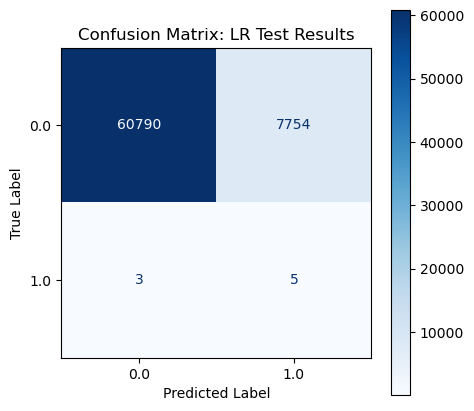

In [108]:
# create X and y
X = df.drop(columns=['injury'])
y = df['injury']

# Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Scale & fit Logistic Regression with balanced weights
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# pass the scaled data back to dataframes to retain column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Initialize Logistic Regression model with default parameters
model_LR = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',
    penalty='l2',  # Using L2 regularization
    random_state=42
)

loo = LeaveOneOut()

K = 5
# Perform Cross-Validation
cv_scores = cross_val_score(model_LR, X_train_scaled, y_train, cv=K, scoring='accuracy')

# Fit model on the entire training set
model_LR.fit(X_train_scaled, y_train)

# Predictions
y_pred_log_reg = model_LR.predict(X_test_scaled)

# Print results
print("\nLogistic Regression Results:")
if K == loo:
    print("Leave_One Out CV")
else:
    print(f"K = {K}")
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(classification_report(y_test, y_pred_log_reg, digits=4))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(model_LR, X_test_scaled, y_test, cmap='Blues', ax=ax)
ax.set_title("Confusion Matrix: LR Test Results")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

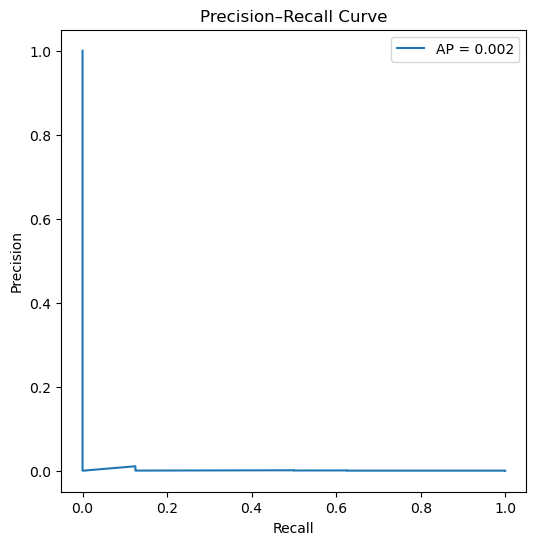

In [109]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
probas = model_LR.predict_proba(X_test_scaled)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, probas, pos_label=1)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'AP = {ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend();


Looking at the confusion matrix and and classification report, this is actually pretty good: 
- Recall (sensitivity) = TP / (TP + FN) = 5 / (5+3) ≈ 0.625
- Precision = TP / (TP + FP) = 5 / (5+7754) ≈ 0.0006

That tiny precision reflects how few of the “injury” predictions are actually correct (because the dataset is extremely imbalanced), while recall of ~62.5% means you’re catching about two-thirds of the true injuries.

However the false positive rate is pretty high. let's try some tuning and see if we can improve the model a bit, first up the penalty parameter (and switching over to cuml for speed)

### Interpretation:
As expected (because we ran this during the last semester) classifier performance is very poor. We're able to get some correct predictions (our true positives) at the expense of many false positives. Let's take a closer look at the misclassified "non-injury" plays that were classified as "injury" plays:

**Our game plan:**
1. Identify misclassified samples: Compare `y_test` with `y_pred_log_reg` and extract the indices where predictions were incorrect.
2. Inspect feature distributions: Check whether misclassified samples have extreme values or different distributions.
3. Visualize misclassified samples: Use scatterplots, boxplots, or PCA to examine patterns.
4. Check feature importance: Look at which features contribute most to the classification.

In [111]:
import seaborn as sns
from sklearn.decomposition import PCA

# Identify misclassified samples
misclassified_indices = np.where(y_test != y_pred_log_reg)[0]
misclassified_samples = X_test_scaled[misclassified_indices]
misclassified_labels = y_test.iloc[misclassified_indices]  # Get true labels
predicted_labels = y_pred_log_reg[misclassified_indices]  # Get predicted labels

# Convert to DataFrame for better analysis
misclassified_df = pd.DataFrame(misclassified_samples, columns=X_train.columns)
misclassified_df['True Label'] = misclassified_labels.values
misclassified_df['Predicted Label'] = predicted_labels

# Display first few misclassified samples
print("\nMisclassified Samples:")
misclassified_df.head()


Misclassified Samples:


,speed_mean,speed_std,speed_min,speed_max,vel_x_mean,vel_x_std,vel_x_min,vel_x_max,vel_y_mean,vel_y_std,...,turn_rate_max,orient_rate_mean,orient_rate_std,orient_rate_min,orient_rate_max,cumulative_dis_max,max_deceleration,play_length,True Label,Predicted Label
0,-1.194761,0.430794,0.163121,0.794025,-0.195525,-0.355867,-1.435673,-0.210144,0.270671,0.443027,...,2.076903,0.161438,-0.077871,0.017970,0.259288,1.155749,-0.210089,4.727718,0.0,1.0
1,1.059076,2.005658,0.157822,1.074258,0.500755,0.339160,-0.255219,0.773617,2.259736,1.782870,...,0.325527,-0.214504,0.196251,-0.507283,-0.245721,1.077918,-0.108033,0.015873,0.0,1.0
2,0.080734,1.300227,0.158696,0.949710,-0.177120,0.111532,-1.269796,-0.356188,1.318401,1.279646,...,1.807923,-0.083223,0.496807,-0.926009,1.294061,-0.390238,-0.057005,0.544259,0.0,1.0
3,1.270266,1.796265,0.158941,1.167669,0.049913,3.573746,-2.238798,2.688420,-1.483490,0.700028,...,2.402414,0.512083,0.302194,-0.306542,0.962340,-0.185568,0.453274,0.117672,0.0,1.0
4,-1.106222,0.050008,0.163443,0.389244,0.022602,-0.681206,0.113888,-0.236937,0.411081,0.236622,...,2.129605,0.014355,0.072882,0.036444,0.279092,1.617162,-0.261117,2.948657,0.0,1.0


To understand where the model misfires, I ran PCA (2 components) on all scaled features of the test set and colored points by prediction correctness (Figure 2). Misclassified cases (red) are concentrated within the same PC1 ≃ –5 to +5 and PC2 ≃ –5 to +5 region as correctly classified points (blue). There is no clear separation between true positives and false positives in this reduced space, indicating that a linear decision boundary cannot disentangle injury vs non-injury plays based on the existing feature set. A handful of misclassifications also appear at more extreme PC1 values, suggesting that outlier events remain problematic.

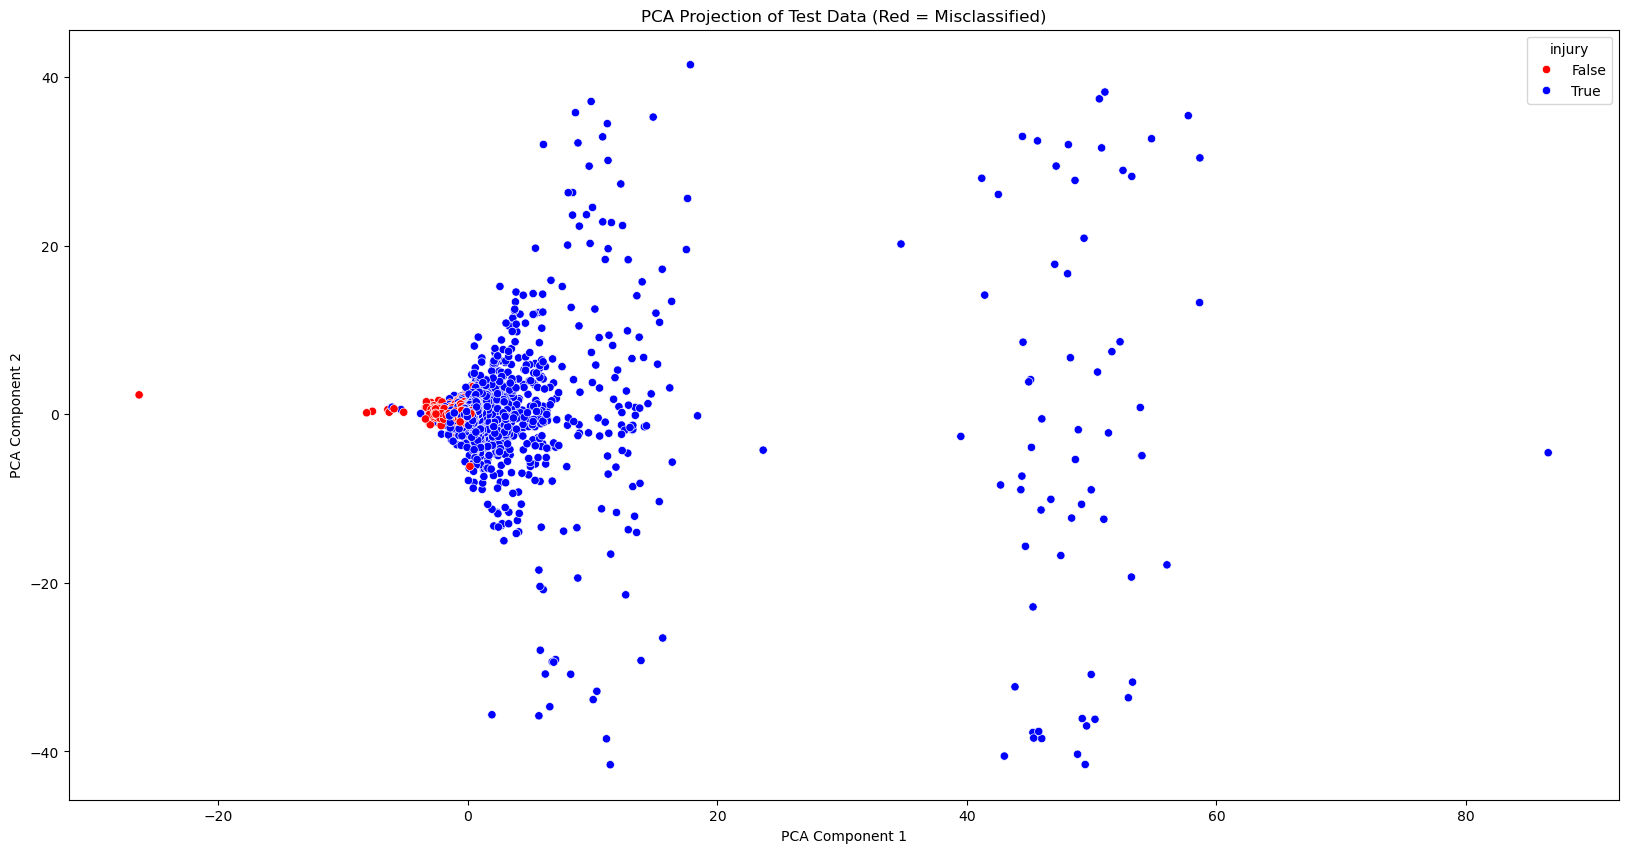

In [116]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(20, 10))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=(y_test == y_pred_log_reg), palette={True: "blue", False: "red"})
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Test Data (Red = Misclassified)")
plt.show()

### check for outliers in features:

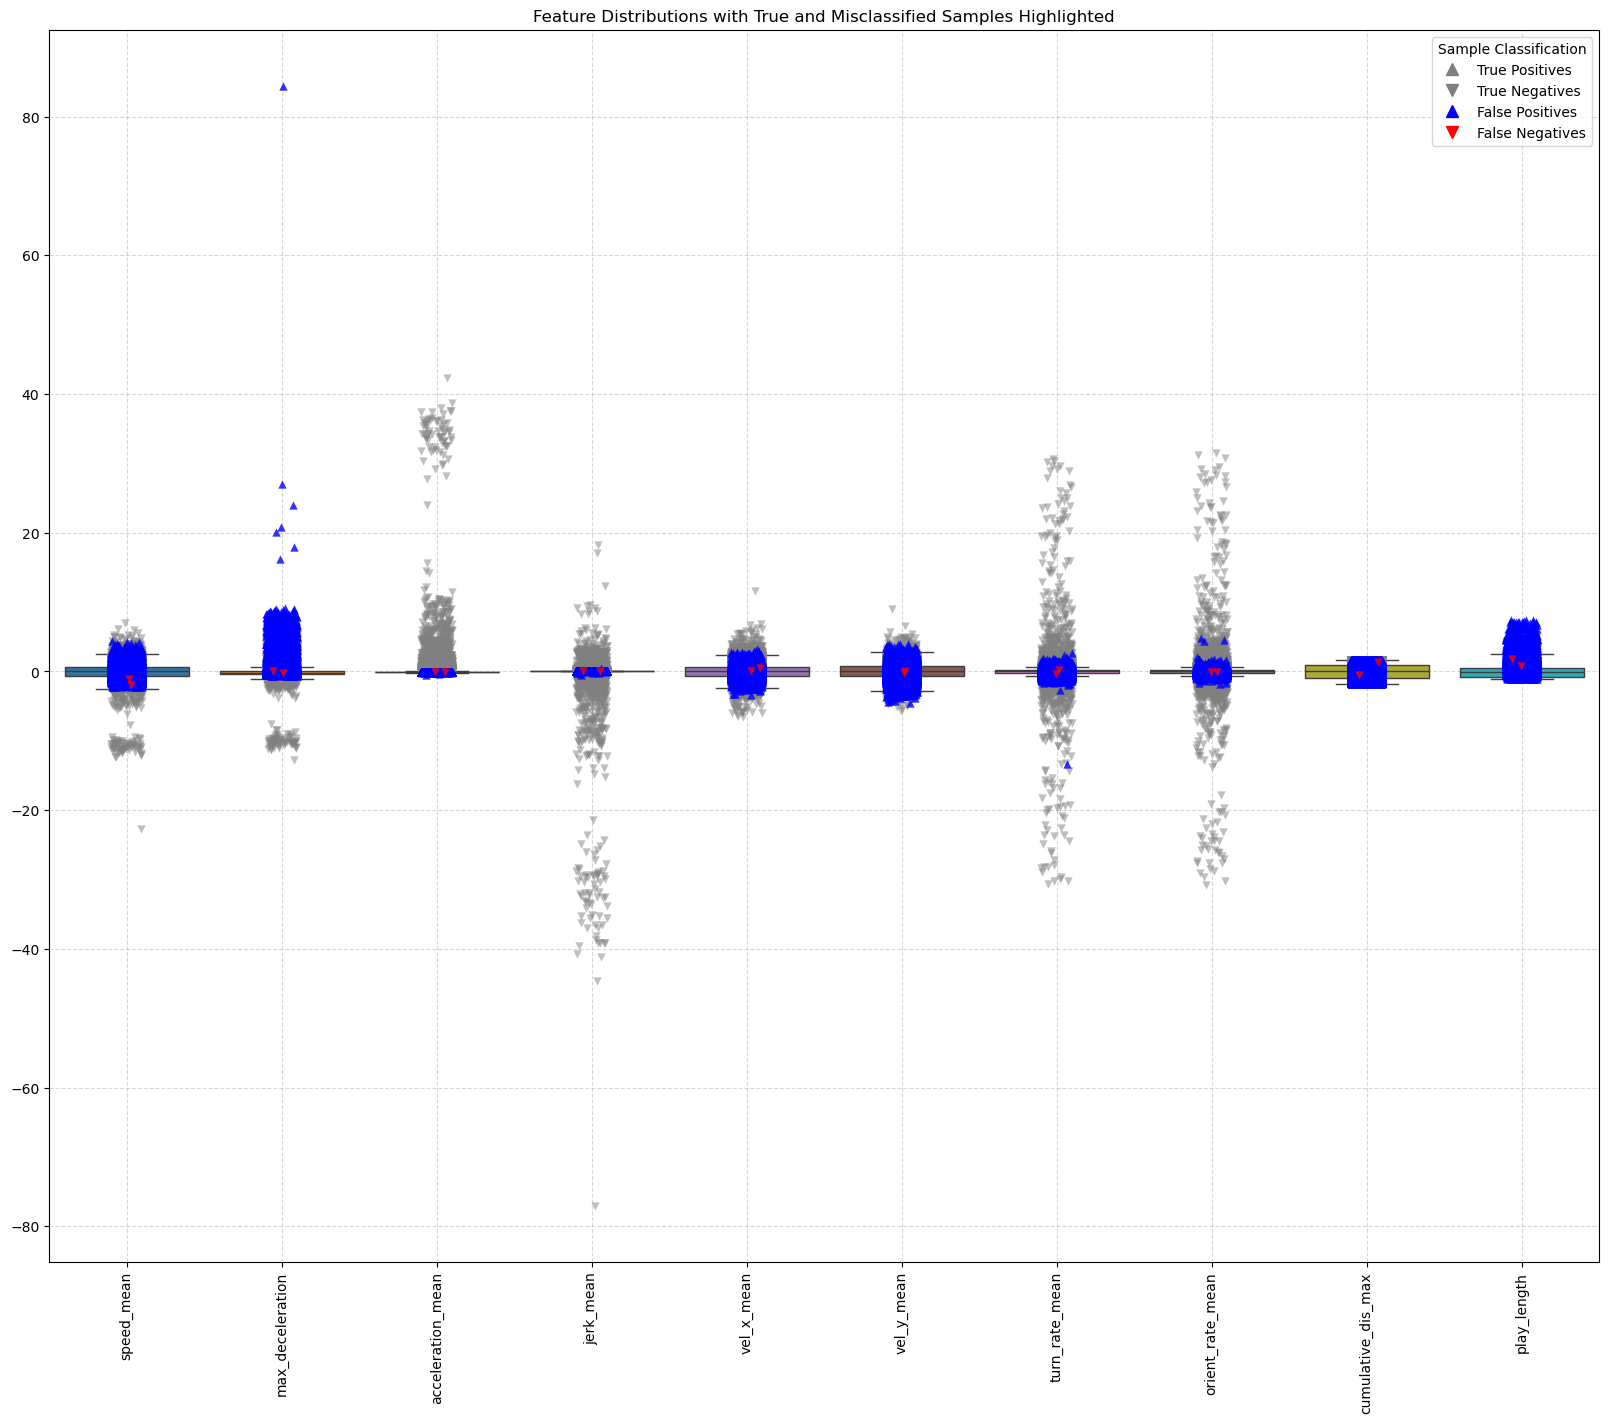

In [117]:

import matplotlib.lines as mlines

# Create DataFrame with scaled features
df_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Ensure y_test and y_pred_log_reg align properly before comparison
df_test['Misclassified'] = (y_test.reset_index(drop=True) != y_pred_log_reg)

# Identify different groups
false_positives = df_test[(df_test['Misclassified']) & (y_pred_log_reg == 1)]  # Predicted 1, actual 0
false_negatives = df_test[(df_test['Misclassified']) & (y_pred_log_reg == 0)]  # Predicted 0, actual 1
true_positives = df_test[~df_test['Misclassified'] & (y_pred_log_reg == 1)]  # Predicted 1, actual 1
true_negatives = df_test[~df_test['Misclassified'] & (y_pred_log_reg == 0)]  # Predicted 0, actual 0

# Drop classification labels from feature DataFrames
df_test = df_test.drop(columns=['Misclassified'])
false_positives = false_positives.drop(columns=['Misclassified'])
false_negatives = false_negatives.drop(columns=['Misclassified'])
true_positives = true_positives.drop(columns=['Misclassified'])
true_negatives = true_negatives.drop(columns=['Misclassified'])

# --- Plot combined boxplot and outliers ---
plt.figure(figsize=(20,16))

# Boxplot for all data (hides standard outliers)
sns.boxplot(data=df_test, showfliers=False)

# Overlay True Positives (gray circles)
sns.stripplot(data=true_positives, color="gray", alpha=0.5, jitter=True, size=6, marker='^')

# Overlay True Negatives (gray squares)
sns.stripplot(data=true_negatives, color="gray", alpha=0.5, jitter=True, size=6, marker='v')

# Overlay False Positives (blue circles)
sns.stripplot(data=false_positives, color="blue", alpha=0.8, jitter=True, size=6, marker='^')

# Overlay False Negatives (red diamonds)
sns.stripplot(data=false_negatives, color="red", alpha=0.8, jitter=True, size=6, marker='v')

# Manually create legend entries using Line2D
legend_handles = [
    mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label="True Positives"),
    mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label="True Negatives"),
    mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=8, label="False Positives"),
    mlines.Line2D([], [], color='red', marker='v', linestyle='None', markersize=8, label="False Negatives"),
]
plt.legend(handles=legend_handles, title="Sample Classification", loc="upper right")

plt.xticks(rotation=90)
plt.title("Feature Distributions with True and Misclassified Samples Highlighted")
plt.grid(linestyle='--', alpha=0.5)
plt.show()

### Play Surface Analytics

In [127]:
motion_df.head()

,DM_M1,DM_M7,DM_M28,DM_M42,PlayerDay,PlayerGame,Temperature,PlayerGamePlay,time_max,dir_max,...,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR,PositionGroup_nan
0,0.0,0.0,0.0,0.0,1.0,1.0,63.0,1.0,29.8,337.87,...,False,False,False,False,True,False,False,False,False,False
1,0.0,0.0,0.0,0.0,1.0,1.0,63.0,10.0,27.5,353.24,...,False,False,False,False,True,False,False,False,False,False
2,0.0,0.0,0.0,0.0,1.0,1.0,63.0,11.0,36.8,357.78,...,False,False,False,False,True,False,False,False,False,False
3,0.0,0.0,0.0,0.0,1.0,1.0,63.0,12.0,35.6,359.97,...,False,False,False,False,True,False,False,False,False,False
4,0.0,0.0,0.0,0.0,1.0,1.0,63.0,13.0,25.5,357.43,...,False,False,False,False,True,False,False,False,False,False



Logistic Regression Results:
K = 5
Cross-Validation Accuracy: 0.8862
Test Accuracy: 0.8720
              precision    recall  f1-score   support

         0.0     0.9997    0.8722    0.9316     53374
         1.0     0.0016    0.4583    0.0032        24

    accuracy                         0.8720     53398
   macro avg     0.5007    0.6653    0.4674     53398
weighted avg     0.9993    0.8720    0.9312     53398



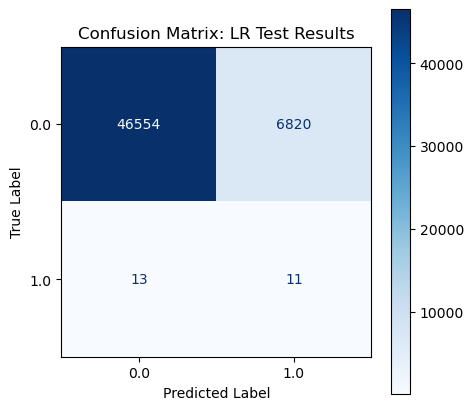

In [123]:
# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report
)

# preprocess data
motion_df = pd.read_csv("/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-playing-surface-analytics/motion_df_encoded.csv")

# Prepare the features (drop leakage columns)
X = motion_df.drop(columns=[
    'Injury', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])

# One-hot encode categorical columns
X = pd.get_dummies(X, dummy_na=True, drop_first=True)

# For a cuDF DataFrame with some boolean columns:
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('int32')


# Prepare the binary target (0 = no injury, 1 = injury)
y = motion_df['Injury'].copy()
y_binary = y.copy()
y_binary[y_binary > 0] = 1

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_binary, 
    test_size=0.2,
    random_state=42,
    shuffle=True       
)

# Scale & fit Logistic Regression with balanced weights
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# Initialize Logistic Regression model with default parameters
model_LR = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',
    penalty='l2',  # Using L2 regularization
    random_state=42
)

loo = LeaveOneOut()

K = 5
# Perform Cross-Validation
cv_scores = cross_val_score(model_LR, X_train_scaled, y_train, cv=K, scoring='accuracy')

# Fit model on the entire training set
model_LR.fit(X_train_scaled, y_train)

# Predictions
y_pred_log_reg = model_LR.predict(X_test_scaled)

# Print results
print("\nLogistic Regression Results:")
if K == loo:
    print("Leave_One Out CV")
else:
    print(f"K = {K}")
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(classification_report(y_test, y_pred_log_reg, digits=4))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(model_LR, X_test_scaled, y_test, cmap='Blues', ax=ax)
ax.set_title("Confusion Matrix: LR Test Results")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Interpretation:
- The high accuracy is misleading, given the extreme class imbalance. 
- The minority class (injury) is barely learned:
    - Of all the times an injury was predicted, only .16% were actually injuries (11 true positives vs. 6,820 false positives).
- Recall for class 1 = 0.4583:
    - only 11 out of 24 real injuries—so we’re missing over half.
- F₁-score for class 1 = 0.0032:
    - That tiny F₁ reflects the disastrous precision + mediocre recall on the positive class.

In [124]:
import seaborn as sns
from sklearn.decomposition import PCA

# Identify misclassified samples
misclassified_indices = np.where(y_test != y_pred_log_reg)[0]
misclassified_samples = X_test_scaled[misclassified_indices]  # Get feature values
misclassified_labels = y_test.iloc[misclassified_indices]  # Get true labels
predicted_labels = y_pred_log_reg[misclassified_indices]  # Get predicted labels

# Convert to DataFrame for better analysis
misclassified_df = pd.DataFrame(misclassified_samples, columns=X_train.columns)
misclassified_df['True Label'] = misclassified_labels.values
misclassified_df['Predicted Label'] = predicted_labels

# Display first few misclassified samples
print("\nMisclassified Samples:")
print(misclassified_df.head())

# Save to CSV for further inspection if needed
misclassified_df.to_csv("misclassified_samples.csv", index=False)


Misclassified Samples:
   PlayerDay  PlayerGame  Temperature  PlayerGamePlay  time_max   dir_max  \
0  -1.141758   -1.534566     0.305927       -0.970082 -0.426969  0.180248   
1  -1.109082   -1.414705     0.371510       -0.766509 -0.683415  0.312590   
2  -1.141758   -1.534566     0.322323       -1.428121 -1.237667 -2.395353   
3   1.145523    0.143489     0.289532        0.200462 -0.344245  0.289614   
4  -0.646180   -0.096234     0.217390       -1.020975 -0.038165  0.322699   

    dis_max     o_max     s_max  angle_max  ...  PositionGroup_LB  \
0 -1.088015 -0.520344 -0.901778  -1.713098  ...         -0.486021   
1  1.063140 -0.070915  1.267242   0.617012  ...          2.057524   
2  0.659799  0.469227  0.808790  -0.215550  ...          2.057524   
3 -0.281331  0.522356 -0.039099   0.565059  ...          2.057524   
4 -1.536172  0.395831 -1.611639   0.229075  ...         -0.486021   

   PositionGroup_OL  PositionGroup_QB  PositionGroup_RB  PositionGroup_SPEC  \
0         -0.464173

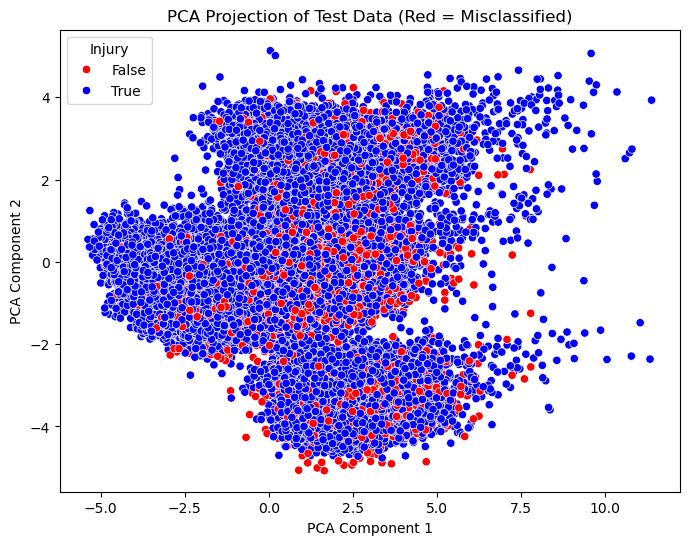

In [125]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=(y_test == y_pred_log_reg), palette={True: "blue", False: "red"})
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Test Data (Red = Misclassified)")
plt.show()

Interpretation: no clear separation between the false-positives and negatives, which helps to visualize that the logistic regression model has no way to easily distinguish between the classes, which is likely causing the poor precision. 

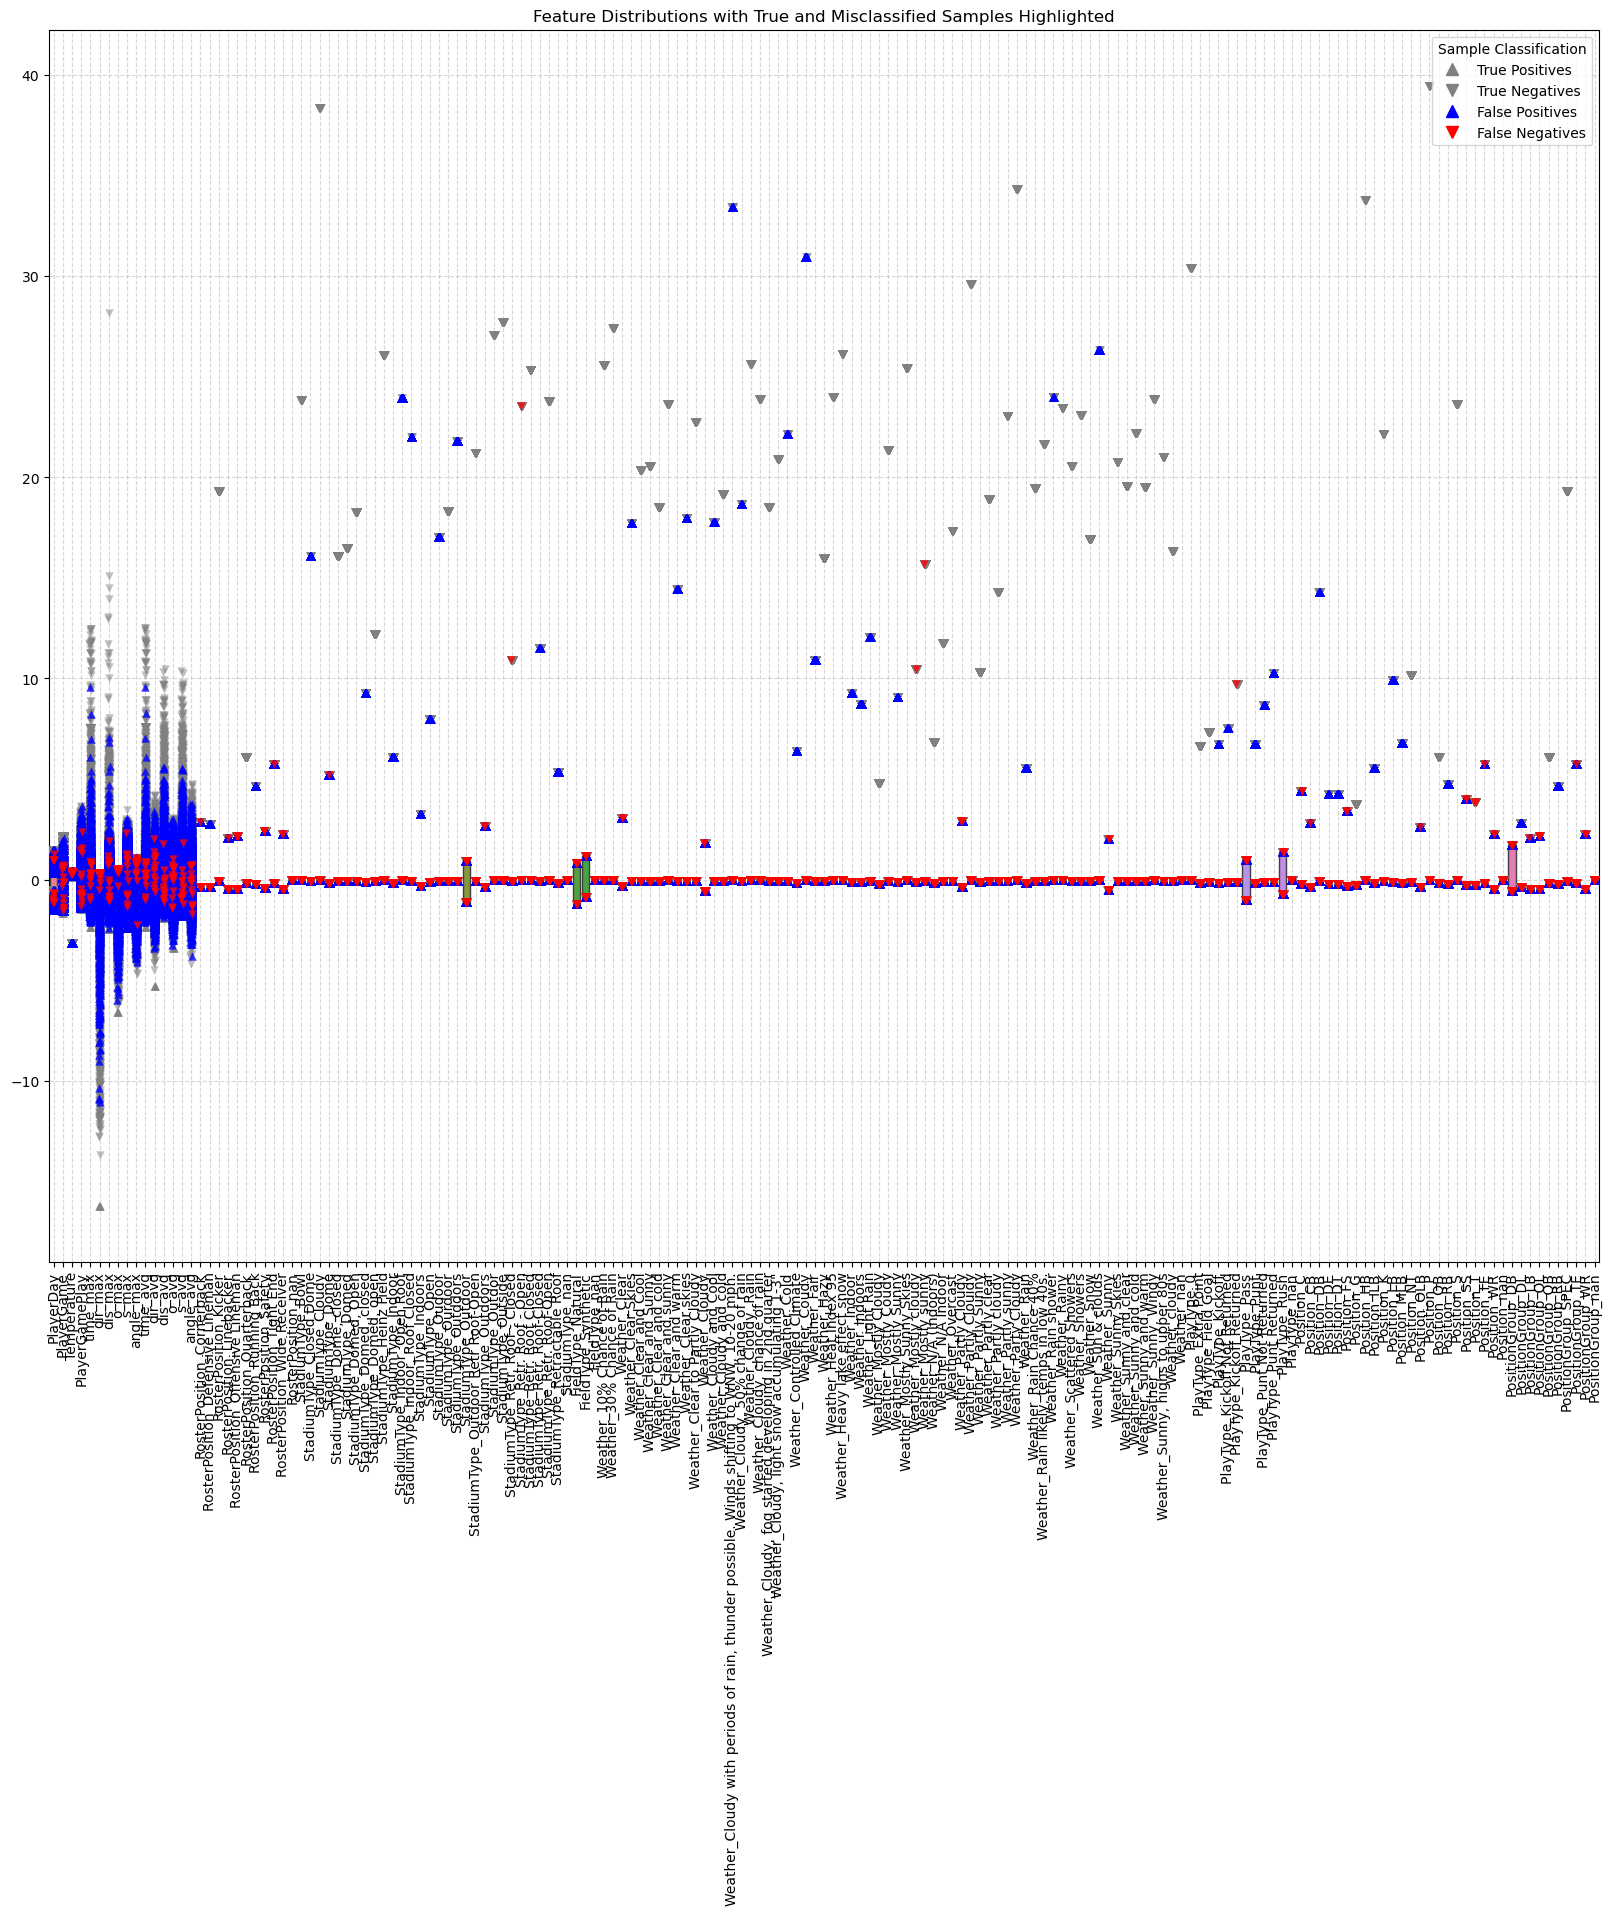

In [126]:

import matplotlib.lines as mlines

# Create DataFrame with scaled features
df_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Ensure y_test and y_pred_log_reg align properly before comparison
df_test['Misclassified'] = (y_test.reset_index(drop=True) != y_pred_log_reg)

# Identify different groups
false_positives = df_test[(df_test['Misclassified']) & (y_pred_log_reg == 1)]  # Predicted 1, actual 0
false_negatives = df_test[(df_test['Misclassified']) & (y_pred_log_reg == 0)]  # Predicted 0, actual 1
true_positives = df_test[~df_test['Misclassified'] & (y_pred_log_reg == 1)]  # Predicted 1, actual 1
true_negatives = df_test[~df_test['Misclassified'] & (y_pred_log_reg == 0)]  # Predicted 0, actual 0

# Drop classification labels from feature DataFrames
df_test = df_test.drop(columns=['Misclassified'])
false_positives = false_positives.drop(columns=['Misclassified'])
false_negatives = false_negatives.drop(columns=['Misclassified'])
true_positives = true_positives.drop(columns=['Misclassified'])
true_negatives = true_negatives.drop(columns=['Misclassified'])

# --- Plot combined boxplot and outliers ---
plt.figure(figsize=(20,16))

# Boxplot for all data (hides standard outliers)
sns.boxplot(data=df_test, showfliers=False)

# Overlay True Positives (gray circles)
sns.stripplot(data=true_positives, color="gray", alpha=0.5, jitter=True, size=6, marker='^')

# Overlay True Negatives (gray squares)
sns.stripplot(data=true_negatives, color="gray", alpha=0.5, jitter=True, size=6, marker='v')

# Overlay False Positives (blue circles)
sns.stripplot(data=false_positives, color="blue", alpha=0.8, jitter=True, size=6, marker='^')

# Overlay False Negatives (red diamonds)
sns.stripplot(data=false_negatives, color="red", alpha=0.8, jitter=True, size=6, marker='v')

# Manually create legend entries using Line2D
legend_handles = [
    mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label="True Positives"),
    mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label="True Negatives"),
    mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=8, label="False Positives"),
    mlines.Line2D([], [], color='red', marker='v', linestyle='None', markersize=8, label="False Negatives"),
]
plt.legend(handles=legend_handles, title="Sample Classification", loc="upper right")

plt.xticks(rotation=90)
plt.title("Feature Distributions with True and Misclassified Samples Highlighted")
plt.grid(linestyle='--', alpha=0.5)
plt.show()

Interpretation: false positives and negatives occur across the entire featureset. This is likely due to a combination of the class imbalances and lack of clear distinguishing features found in the data representation. Some of the more advanced classifiers do a little better, but this is a common trend across my analysis thus far.